## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_diagonal_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/diagonal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4500,
 3: 18000,
 4: 72000,
 5: 288000,
 6: 1152000,
 7: 4608000,
 8: 18432000,
 9: 73728000,
 10: 294912000}

Running 12760 CDFs


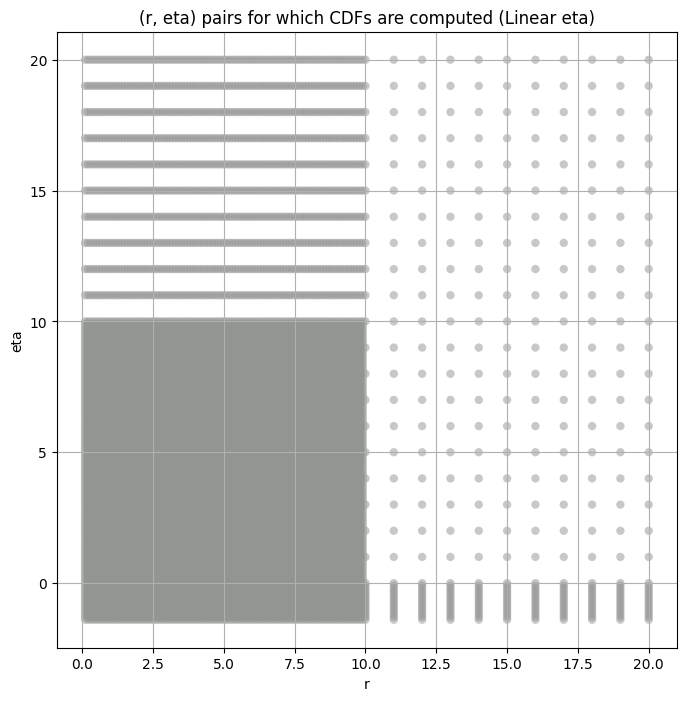

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      48477.156000  20407.244000  98426.120000   464.3678   99.549120   
3       9444.763000   5309.856400  15352.427000   431.8413  166.979080   
4       2098.490200    931.151060   4352.503000  1066.9325  136.693400   
5        347.001600    166.507490    821.238000  1301.6492   85.055270   
6         95.132810     42.791160    309.412260  3018.1877   62.344480   
7         27.165165     14.275747     79.906204  2270.9495   50.703800   
8         10.935260      5.523009     31.109842  1948.5700   69.621250   
9          1.818054      0.995189      4.794515  1645.8049   67.103200   
10         0.179641      0.079249      0.817442  5707.5054   74.193924   

       kurt_upper  total_samples  
layer                             
2        783.3673         4500.0  
3        690.7381        18000.0  
4       2116.3550        72000.0  
5       3381.1282       288000.0  
6       5098.2686      1152000.0  
7       4215.7363      4608000.0  
8       4228.2856     18432000.0  
9       3605.7570     73728000.0  
10      6393.3745    294912000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      48477.156000   48477.156250     8848.582031     7054.935547   
3       9444.763000    9444.762695     2845.853027     2284.004883   
4       2098.490200    2098.490234      873.411560      688.510254   
5        347.001600     347.001587      172.324249      145.252594   
6         95.132810      95.132812       44.391968       38.538822   
7         27.165165      27.165165       14.803882       13.044334   
8         10.935260      10.935260        5.759601        4.940436   
9          1.818054       1.818054        1.041454        0.896445   
10         0.179641       0.179641        0.083441        0.071211   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5928.476562      5128.053711      4021.412354      3255.614746   
3         1997.458862      1805.571167      1546.392334      1364.346924   
4          608.250305       553.560791       487.437439       442.294067   
5          131.444901       121.944931       109.183411       100.700684   
6           35.313133        33.141098        30.260469        28.331900   
7           12.060283        11.398344        10.514847         9.920958   
8            4.503266         4.218316         3.856113         3.621574   
9            0.817579         0.766381         0.700306         0.655834   
10           0.064581         0.060277         0.054678         0.050891   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          2710.315430      2305.930176      1981.525391      1314.435547  
3          1225.761719      1116.465088      1026.590088       823.592957  
4           410.879028       385.760773       364.701111       317.064331  
5            94.406570        89.311890        85.048882        75.442406  
6            26.884607        25.727234        24.761848        22.571598  
7             9.475535         9.118292         8.818915         8.129410  
8             3.447487         3.307564         3.189886         2.916104  
9             0.621802         0.593959         0.570299         0.514740  
10            0.047988         0.045611         0.043589         0.038843

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02887306487130542 48477.156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.01135128564088106 8848.582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.01741089637301649 7054.9355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.023474052644569574 5928.4766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.027953316006145625 5128.0537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.03685347532415706 4021.4124


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.04923307746544503 3255.6147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.060697785396454096 2710.3154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.07084404125652022 2305.9302


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.079928573302819 1981.5254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.11127689030701016 1314.4355
Number of samples: 4500, Without approximation : 4500.0


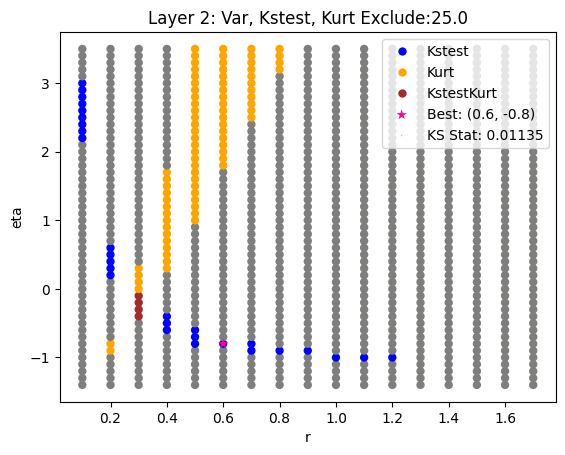

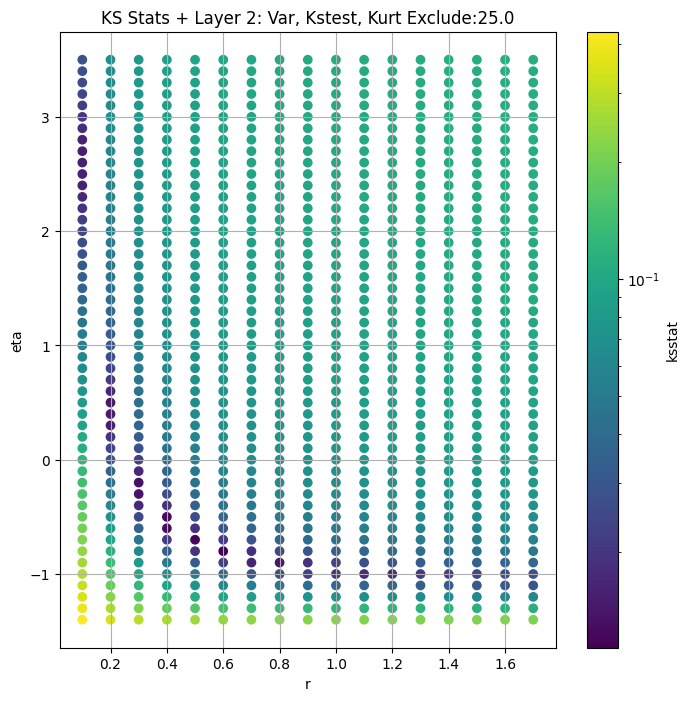

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.03141818631145382 9444.763


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.011348047937647598 2845.853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.007555890393839082 2284.005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.008293707647363032 1997.4589


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.010582338583690898 1805.5712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.012610771473018789 1546.3923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.01577775837424822 1364.3469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01876482687464731 1225.7617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.021827662237828727 1116.4651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.024835319977934867 1026.5901


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.032949633249958366 823.59296
Number of samples: 18000, Without approximation : 18000.0


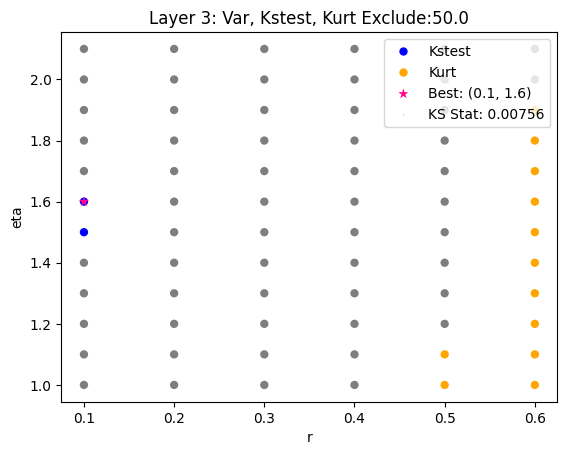

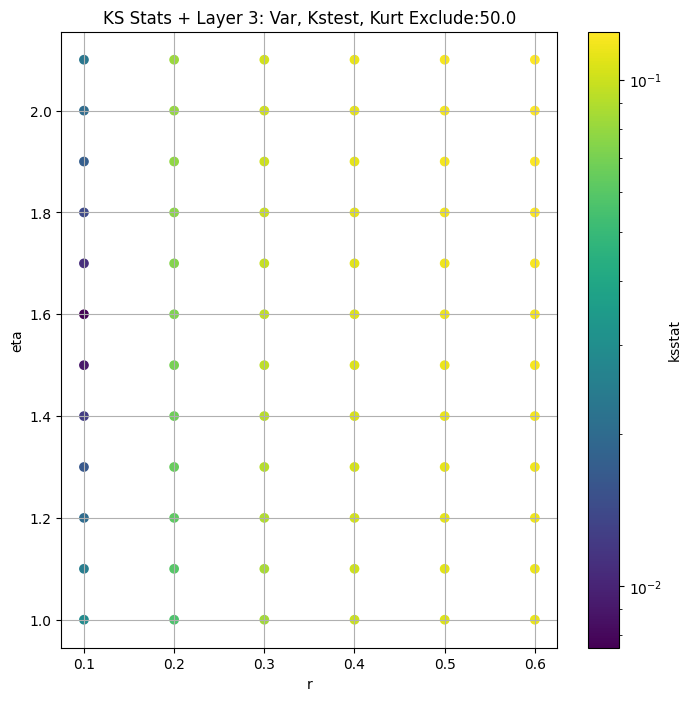

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03534608994970767 2098.4902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.02058403472768823 873.41156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.01690225422402286 688.51025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.01528199839664321 608.2503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.012583191961176632 553.5608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.011345151139819376 487.43744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.009252120067707897 442.29407


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008040916117551755 410.87903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.008456389431984124 385.76077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.009513154997696227 364.7011


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.01145612917745964 317.06433
Number of samples: 72000, Without approximation : 72000.0


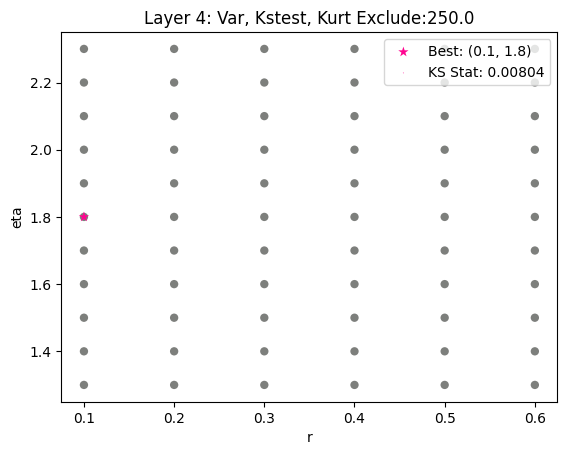

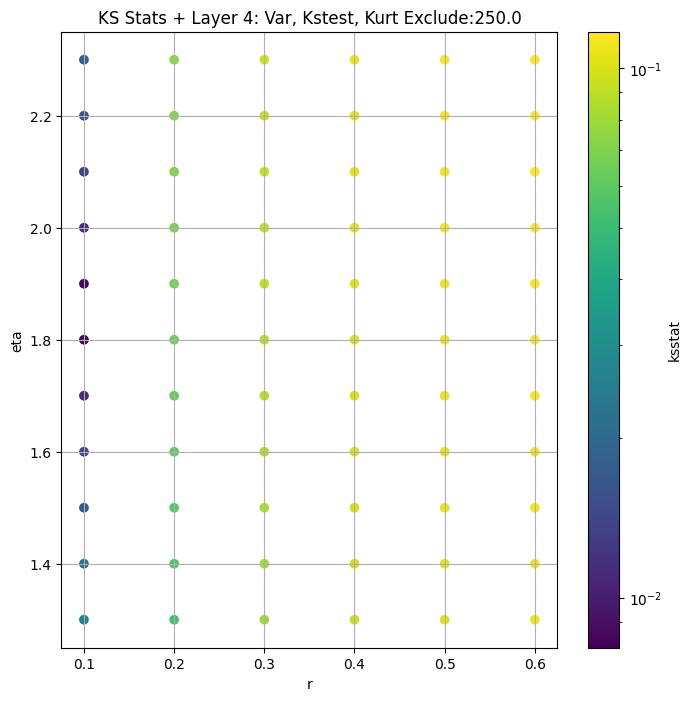

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03175445246199482 347.0016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.018527051157156582 172.32425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.014885647539268132 145.2526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.012629387546852944 131.4449


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010756856159874373 121.94493


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007910537162386544 109.18341


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0066077021145790615 100.70068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.004838293176366526 94.40657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.004926660793398985 89.31189


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.005468070404904268 85.04888


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0070364466482117916 75.442406
Number of samples: 100000, Without approximation : 288000.0


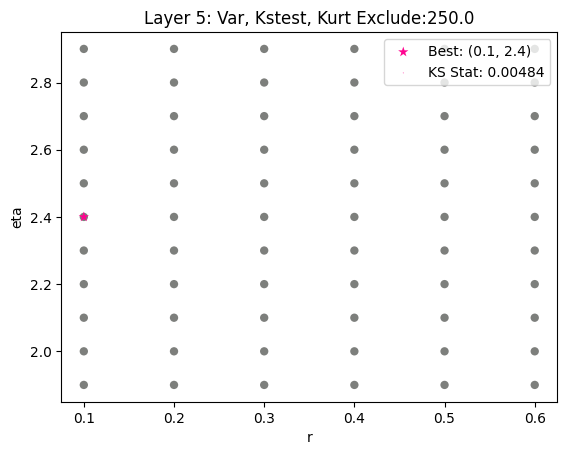

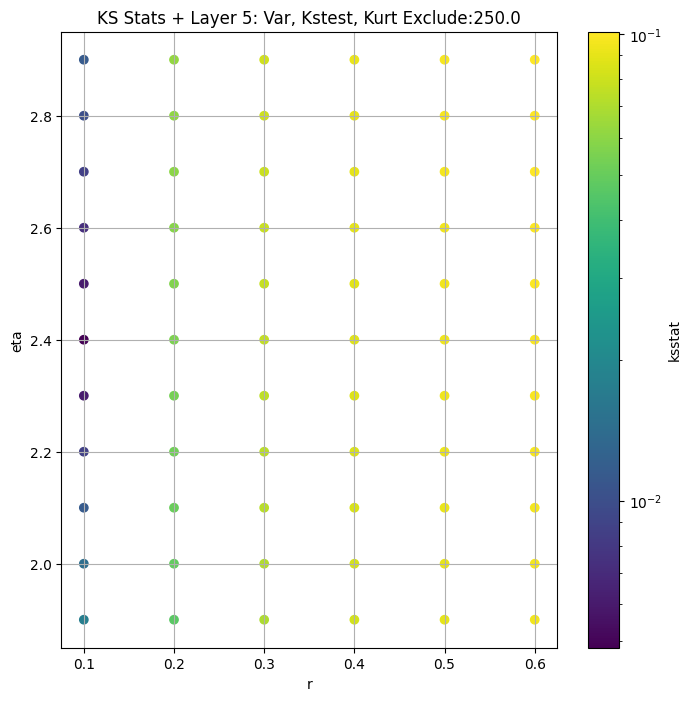

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.027841389262706406 95.13281


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.012035580675934354 44.391968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.00863778982809471 38.538822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.0064510369877552876 35.313133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.004476971236051175 33.141098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.002359530243569473 30.26047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.002902126605615604 28.3319


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.003491459659636981 26.884607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.004057885105464917 25.727234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.00476553505125871 24.761848


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.0065158619852853095 22.571598
Number of samples: 100000, Without approximation : 1152000.0


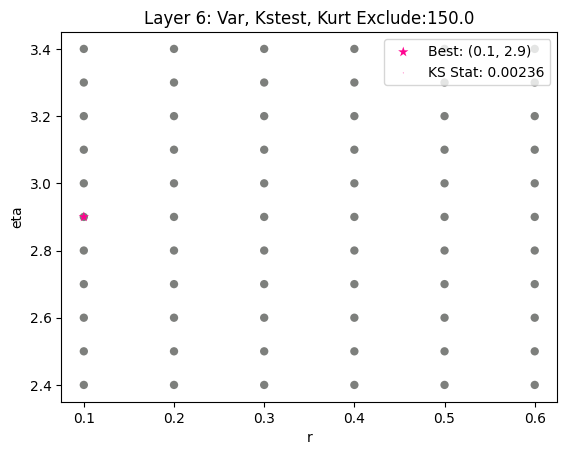

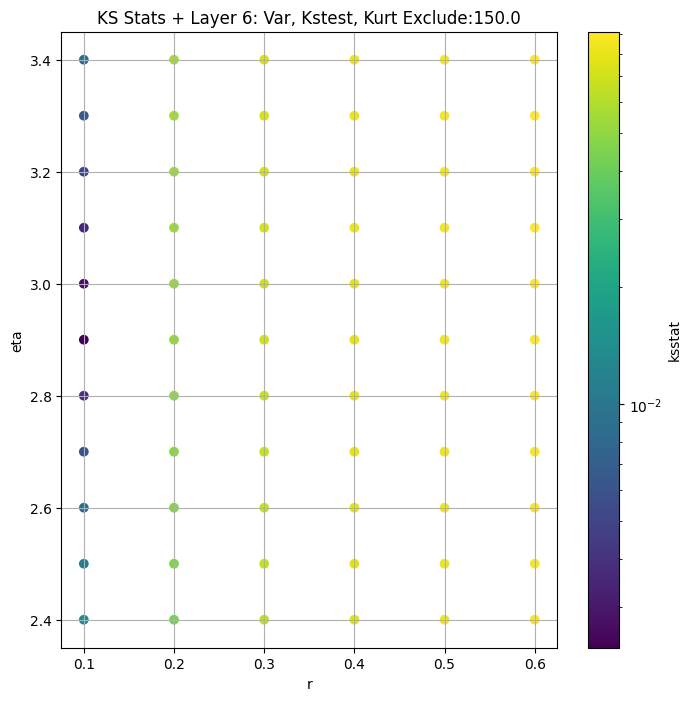

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.02206786454189924 27.165165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.007964543030514193 14.803882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.004795961435567153 13.044334


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0028159455828201674 12.060283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.0018563370288583458 11.398344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0021069154646933264 10.514847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0027199187051334395 9.920958


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0034900641405397614 9.475535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.004155143367411827 9.118292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.004951636879864637 8.818915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.00706340468095543 8.12941
Number of samples: 100000, Without approximation : 4608000.0


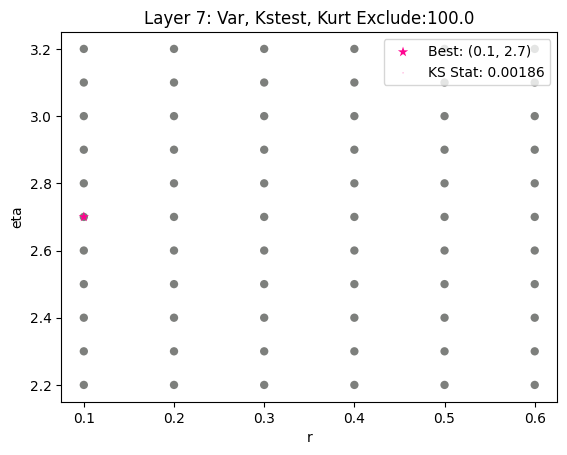

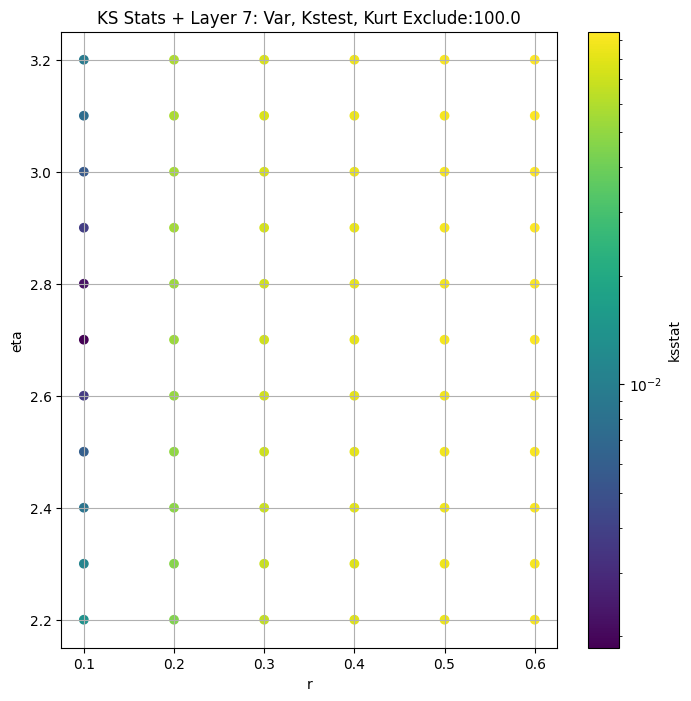

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.02594409419282162 10.93526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.011820842396834924 5.759601


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.0076529361491222 4.940436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006563520556554167 4.5032663


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005132880189272049 4.2183156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0031110387088850167 3.856113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0038438509443006197 3.6215744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.004394947405437999 3.4474874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0049573017554429555 3.3075638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005585448121512182 3.1898863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00768513300926188 2.916104
Number of samples: 100000, Without approximation : 18432000.0


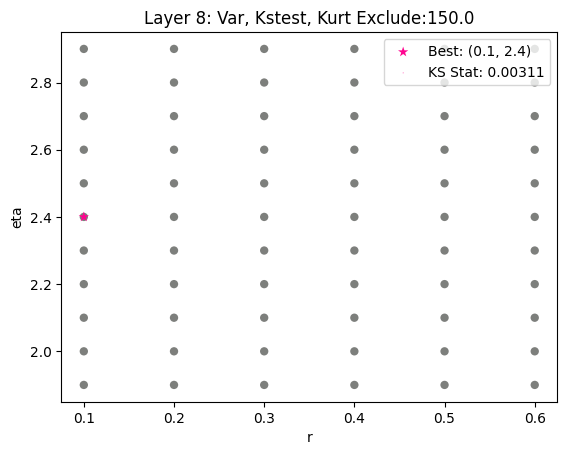

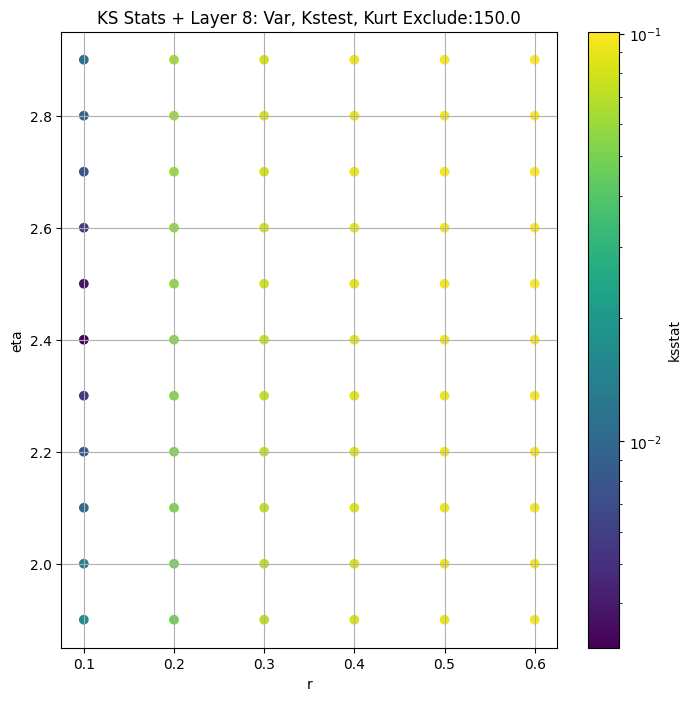

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.025918710494189756 1.8180541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013851474014530032 1.0414543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.012137632990570121 0.89644533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.00967846882885598 0.81757903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.008655634179329796 0.7663814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.006714861705055919 0.70030576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0058366508622703095 0.655834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.005405387291632868 0.6218019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.0062530350007176105 0.59395874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.006505221181064558 0.5702987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.0080719556832608 0.51473975
Number of samples: 100000, Without approximation : 73728000.0


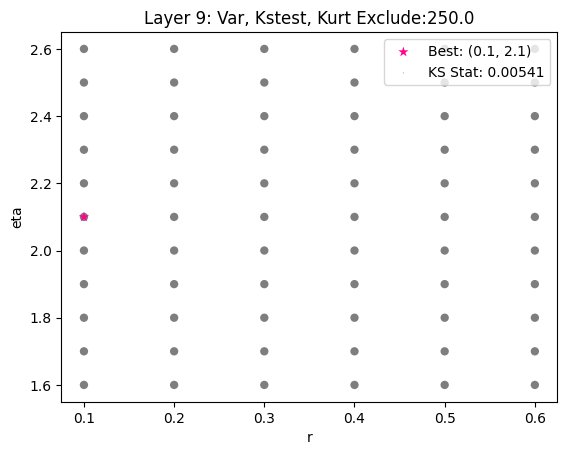

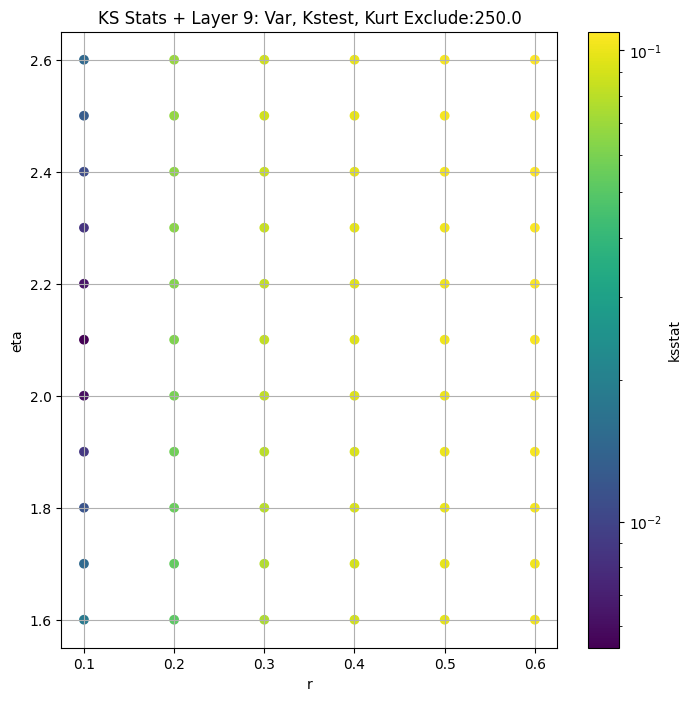

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.03147019668399473 0.17964144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.017861466866056497 0.08344147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.015151939530244019 0.07121092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.01457760902231442 0.06458142


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.013429944315667353 0.060276773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.010873249155473053 0.05467752


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.009867371196622732 0.05089096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.009241266769599132 0.04798763


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.008445951914179073 0.04561097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.008018654531442682 0.04358854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.009383930053139422 0.038843025
Number of samples: 100000, Without approximation : 294912000.0


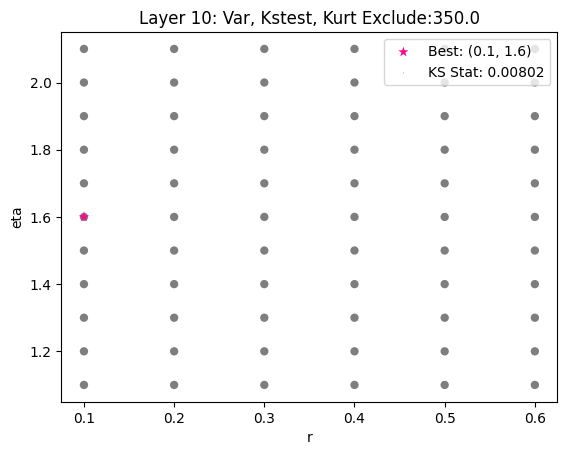

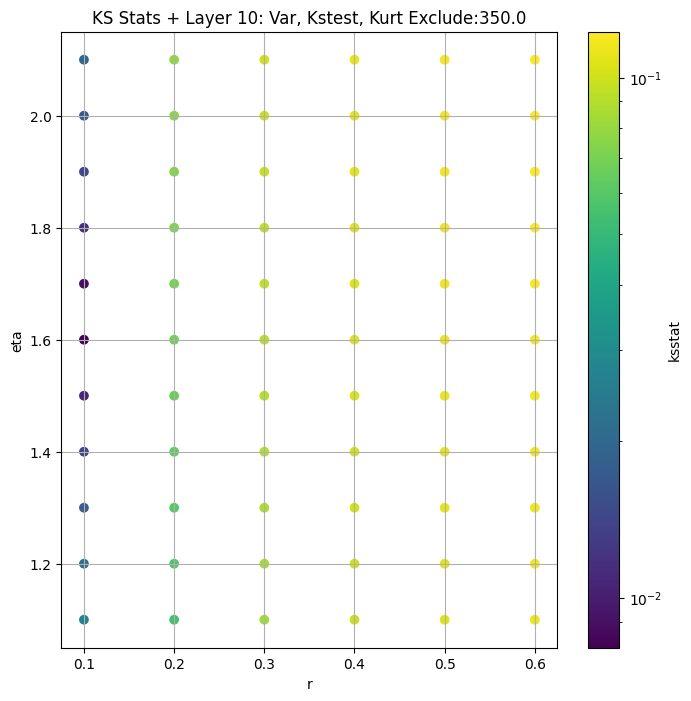

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      48477.156000  20407.244000  98426.120000   464.3678   99.549120   
3       9444.763000   5309.856400  15352.427000   431.8413  166.979080   
4       2098.490200    931.151060   4352.503000  1066.9325  136.693400   
5        347.001600    166.507490    821.238000  1301.6492   85.055270   
6         95.132810     42.791160    309.412260  3018.1877   62.344480   
7         27.165165     14.275747     79.906204  2270.9495   50.703800   
8         10.935260      5.523009     31.109842  1948.5700   69.621250   
9          1.818054      0.995189      4.794515  1645.8049   67.103200   
10         0.179641      0.079249      0.817442  5707.5054   74.193924   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        783.3673         4500.0             0.011351        0.6         -0.8   
3        690.7381        18000.0             0.007556        0.1          1.6   
4       2116.3550        72000.0             0.008041        0.1          1.8   
5       3381.1282       288000.0             0.004838        0.1          2.4   
6       5098.2686      1152000.0             0.002360        0.1          2.9   
7       4215.7363      4608000.0             0.001856        0.1          2.7   
8       4228.2856     18432000.0             0.003111        0.1          2.4   
9       3605.7570     73728000.0             0.005405        0.1          2.1   
10      6393.3745    294912000.0             0.008019        0.1          1.6   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.760122e+03                    25.0         8848.582000   
3       7.425266e-13                    50.0         2284.005000   
4       7.694980e-14                   250.0          410.879030   
5       3.977534e-15                   250.0           94.406570   
6       4.276594e-16                   150.0           30.260470   
7       2.458248e-16                   100.0           11.398344   
8       1.624656e-16                   150.0            3.856113   
9       5.371219e-17                   250.0            0.621802   
10      1.417057e-17                   350.0            0.043589   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.020208  
3                     0.010113  
4                     0.005059  
5                     0.002530  
6                     0.001265  
7                     0.000633  
8                     0.000316  
9                     0.000158  
10                    0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.034076455679167617, var: 4516.25341796875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.028209341465755156, var: 5128.0537109375


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.02368716842774785, var: 5928.4765625


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.017939711913819007, var: 7054.935546875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.01111119526011677, var: 8848.58203125


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.032441285268398345, var: 48477.15625
Number of samples: 4500, Without approximation : 4500.0


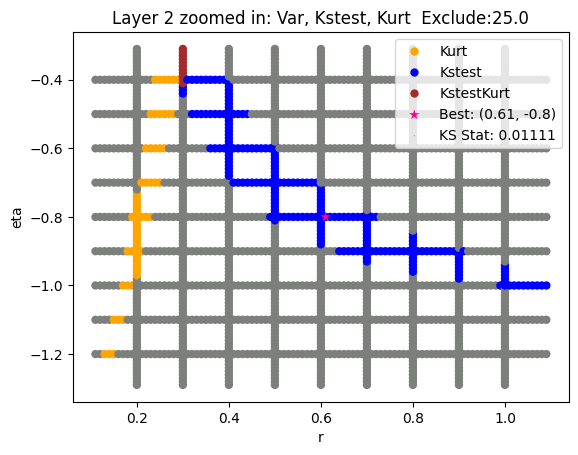

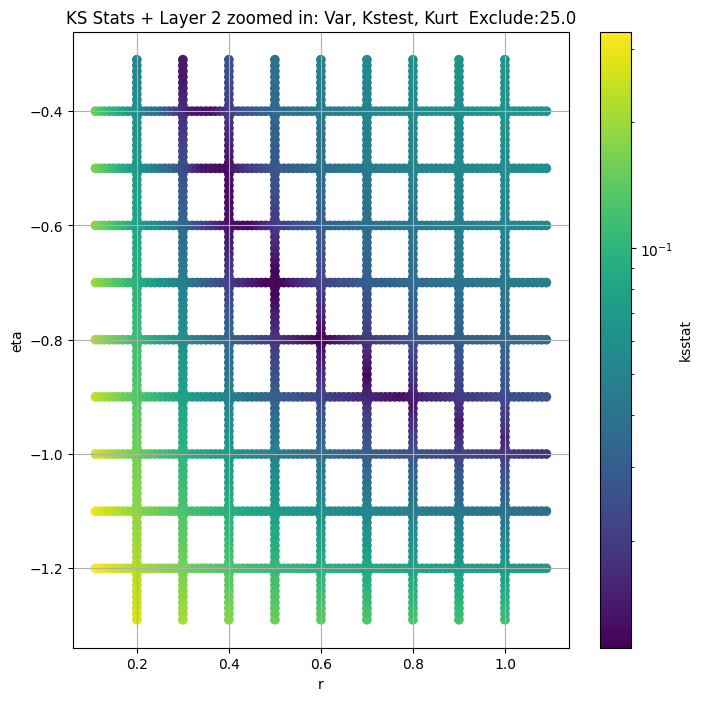

Layer 3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + 100 = 150, ksstat: 0.015620432194440537, var: 1546.392333984375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + 75 = 125, ksstat: 0.013663521952235858, var: 1659.4193115234375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + 50 = 100, ksstat: 0.011795748193624611, var: 1805.5711669921875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + 25 = 75, ksstat: 0.009530577247319205, var: 1997.4588623046875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + 0 = 50, ksstat: 0.007510226517256469, var: 2284.0048828125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + -25 = 25, ksstat: 0.009692816712093016, var: 2845.85302734375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 50.0 + -50 = 0, ksstat: 0.026299430636733984, var: 9444.7626953125
Number of samples: 18000, Without approximation : 18000.0


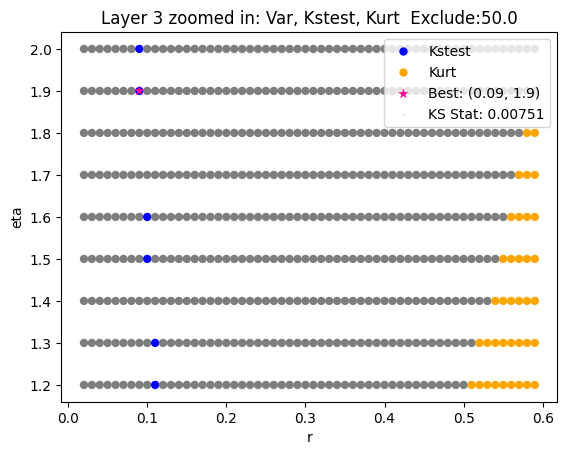

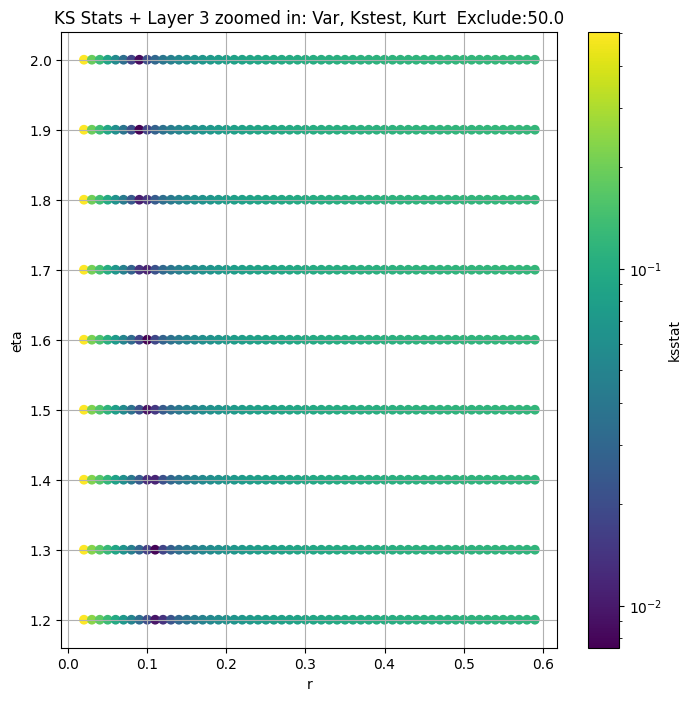

Layer 4


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.009398216876248422, var: 364.70111083984375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.008885017287791785, var: 374.7900085449219


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.008348316930596233, var: 385.7607727050781


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.00785172717886351, var: 397.66522216796875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.00758244212007686, var: 410.8790283203125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.008314465418607142, var: 425.6472473144531


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.009016412643905625, var: 442.2940673828125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.009506078154665532, var: 462.7087097167969


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.009786829132243935, var: 487.43743896484375
Number of samples: 72000, Without approximation : 72000.0


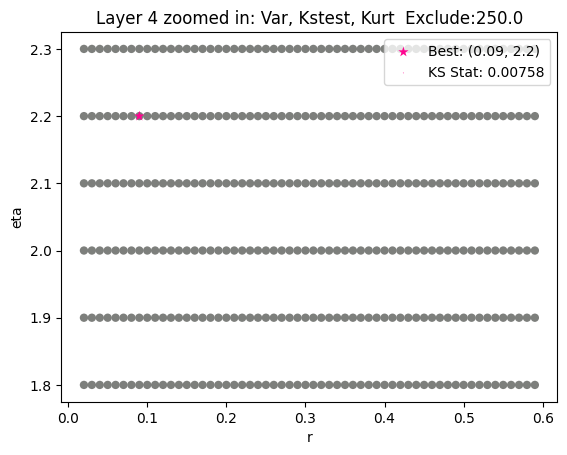

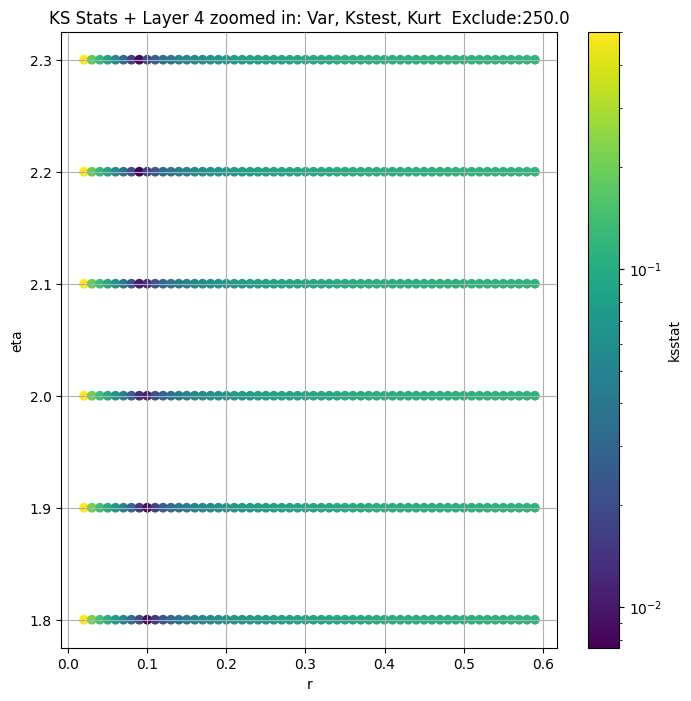

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 100 = 350, ksstat: 0.0054609947120310975, var: 85.04888153076172


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 75 = 325, ksstat: 0.005170563582797216, var: 87.09075164794922


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 50 = 300, ksstat: 0.004915508222405052, var: 89.3118896484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 25 = 275, ksstat: 0.004596616511315377, var: 91.73145294189453


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + 0 = 250, ksstat: 0.0047755216736578565, var: 94.40657043457031


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -25 = 225, ksstat: 0.005075957424983013, var: 97.36066436767578


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -50 = 200, ksstat: 0.005848987569894715, var: 100.70068359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -75 = 175, ksstat: 0.0070716411799511825, var: 104.54591369628906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 250.0 + -100 = 150, ksstat: 0.007726976480385894, var: 109.18341064453125
Number of samples: 100000, Without approximation : 288000.0


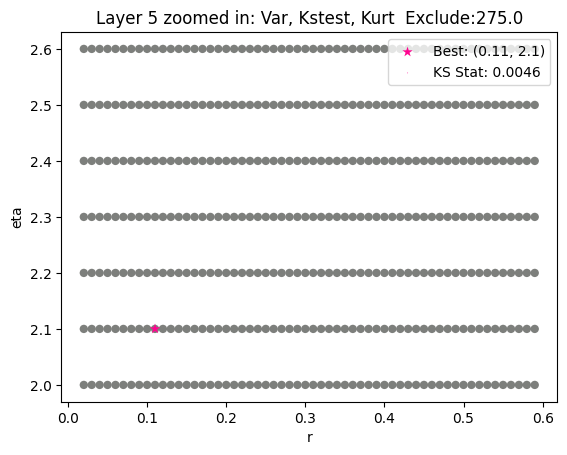

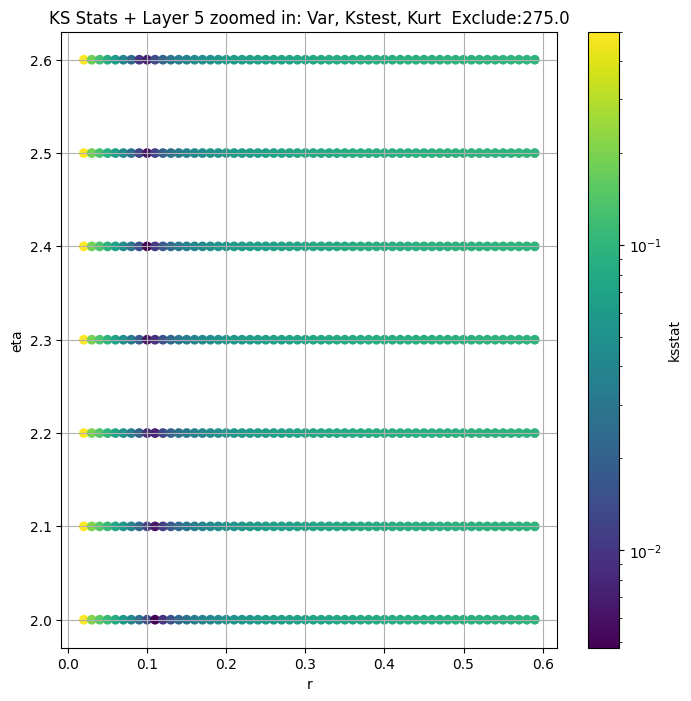

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.0034416285183455422, var: 26.884607315063477


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.0031423453530907836, var: 27.563535690307617


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.002880139172720788, var: 28.331899642944336


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.0026101975441175235, var: 29.21624183654785


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.002359530243569473, var: 30.260469436645508


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.0028867070216265223, var: 31.529613494873047


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.004418465090730073, var: 33.14109802246094


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.0058877697202327495, var: 35.313133239746094


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.007881409151817897, var: 38.538822174072266
Number of samples: 100000, Without approximation : 1152000.0


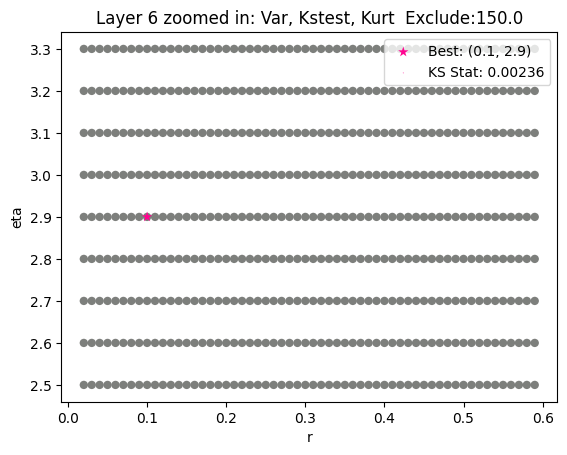

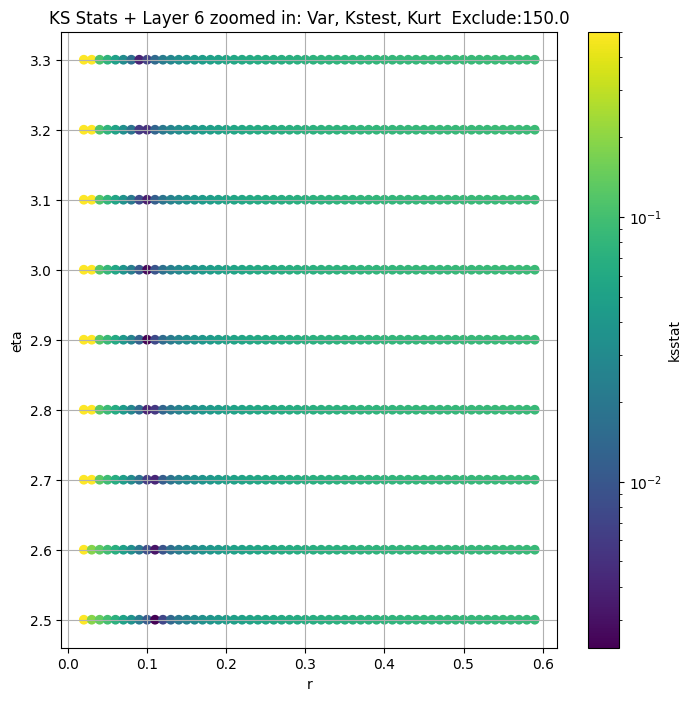

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + 100 = 200, ksstat: 0.0031948811765415072, var: 9.920957565307617


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + 75 = 175, ksstat: 0.002471595618111888, var: 10.1932373046875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + 50 = 150, ksstat: 0.002140611354674027, var: 10.514846801757812


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + 25 = 125, ksstat: 0.0021433698805794488, var: 10.90538215637207


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + 0 = 100, ksstat: 0.00180655826197601, var: 11.398344039916992


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + -25 = 75, ksstat: 0.0027782239094121808, var: 12.060282707214355


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + -50 = 50, ksstat: 0.0049870048558970925, var: 13.044334411621094


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + -75 = 25, ksstat: 0.007472507030794218, var: 14.803881645202637


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 100.0 + -100 = 0, ksstat: 0.01924952273632735, var: 27.165164947509766
Number of samples: 100000, Without approximation : 4608000.0


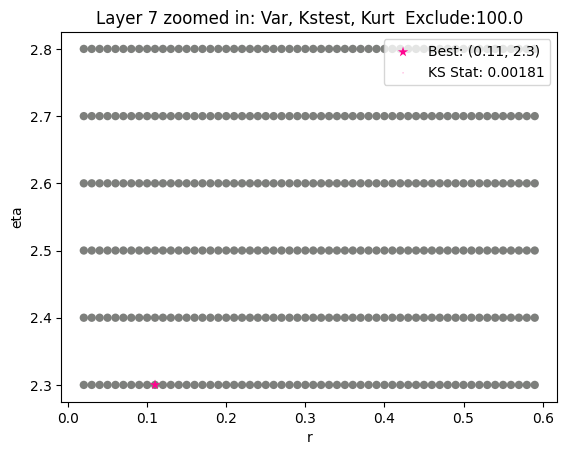

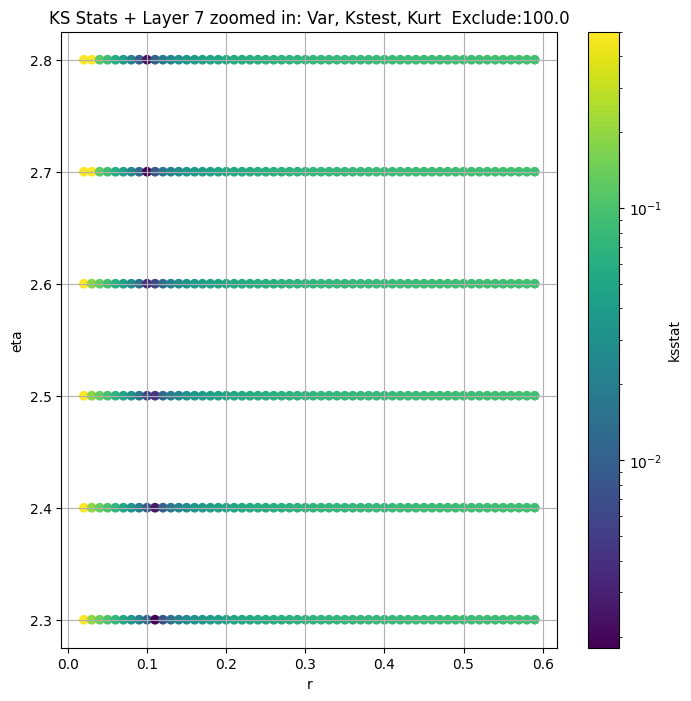

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.004786121171597824, var: 3.4474873542785645


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.004266457264956558, var: 3.5291831493377686


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.003718450889913294, var: 3.6215744018554688


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.003181118629944857, var: 3.728637933731079


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.0031110387088850167, var: 3.8561129570007324


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.003311401906446243, var: 4.01369571685791


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.004421886245168372, var: 4.218315601348877


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.0060100634330301494, var: 4.503266334533691


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.007503555603923878, var: 4.940435886383057
Number of samples: 100000, Without approximation : 18432000.0


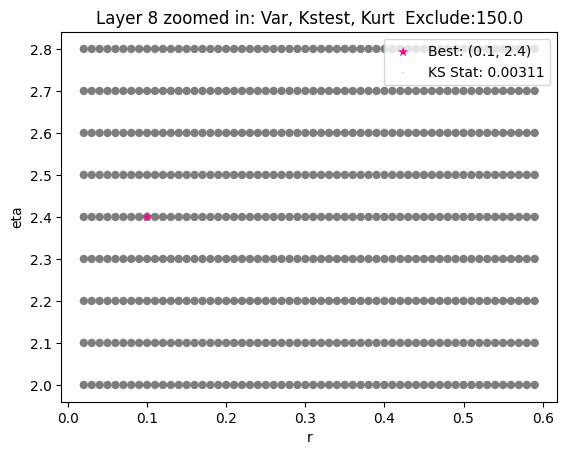

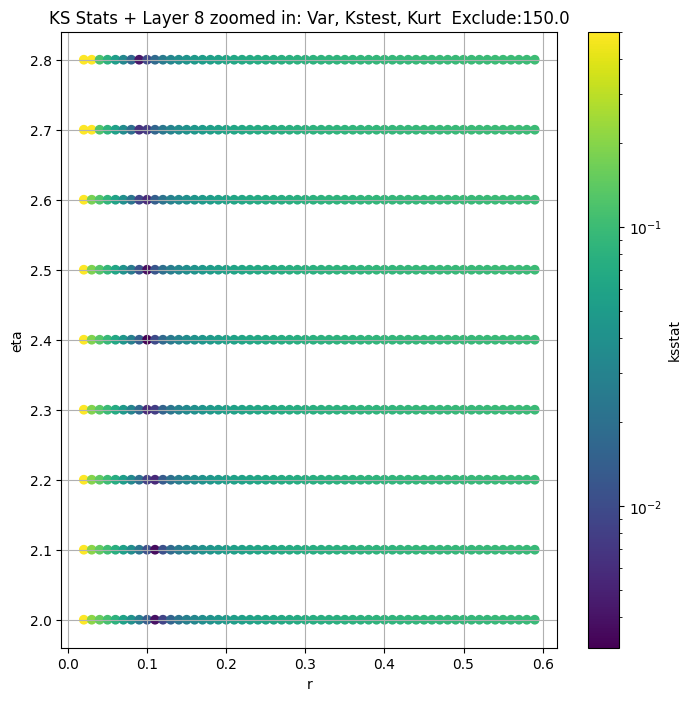

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + 100 = 350, ksstat: 0.0069190818831240675, var: 0.5702986717224121


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + 75 = 325, ksstat: 0.006529902160098966, var: 0.5816941857337952


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + 50 = 300, ksstat: 0.00620000452152325, var: 0.5939587354660034


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + 25 = 275, ksstat: 0.005787873586557524, var: 0.6072583794593811


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + 0 = 250, ksstat: 0.005360694520300857, var: 0.6218019127845764


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + -25 = 225, ksstat: 0.004952417349839866, var: 0.6378538012504578


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + -50 = 200, ksstat: 0.005605410836027225, var: 0.6558340191841125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + -75 = 175, ksstat: 0.005959580373588819, var: 0.6763439774513245


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 250.0 + -100 = 150, ksstat: 0.006538296144517647, var: 0.7003057599067688
Number of samples: 100000, Without approximation : 73728000.0


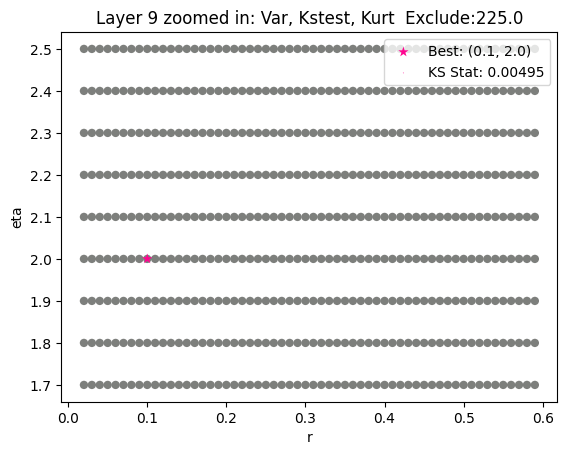

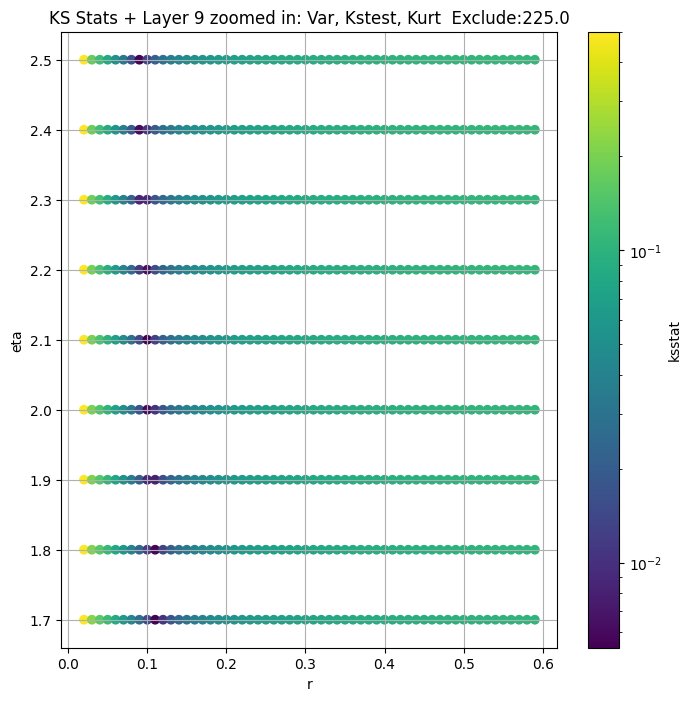

Layer 10


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 100 = 450, ksstat: 0.009218130351342335, var: 0.04025525972247124


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 75 = 425, ksstat: 0.008917110547780882, var: 0.041017670184373856


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 50 = 400, ksstat: 0.008509546190578088, var: 0.04182354360818863


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 25 = 375, ksstat: 0.008241709031228228, var: 0.042678315192461014


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 0 = 350, ksstat: 0.007918025974762766, var: 0.0435885414481163


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -25 = 325, ksstat: 0.007738151290395623, var: 0.044562630355358124


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -50 = 300, ksstat: 0.007400544266695147, var: 0.04561097174882889


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -75 = 275, ksstat: 0.008509163372837109, var: 0.04674685001373291


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -100 = 250, ksstat: 0.008569997828565545, var: 0.04798762872815132
Number of samples: 100000, Without approximation : 294912000.0


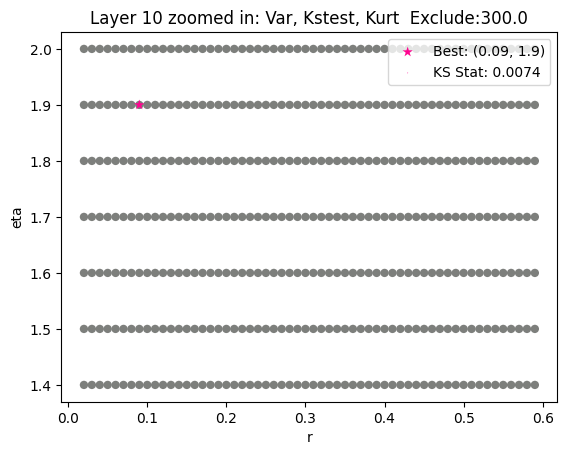

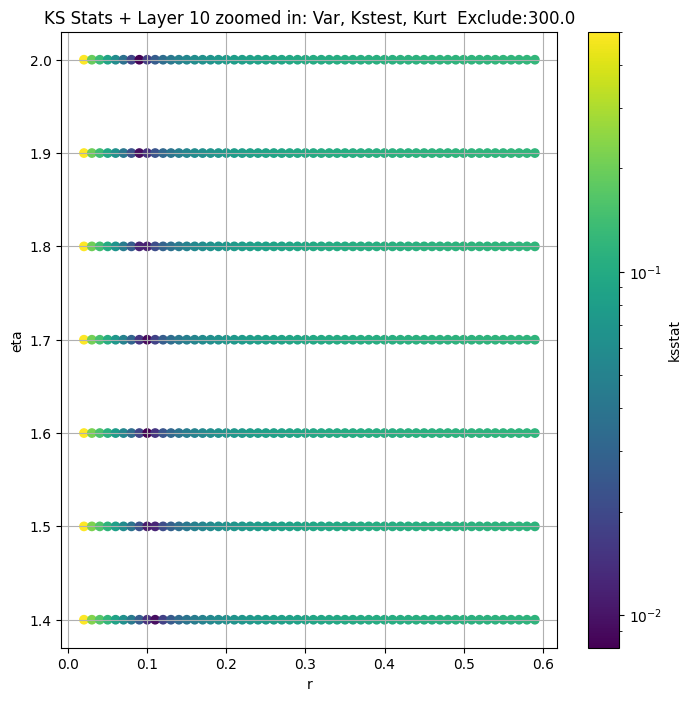

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      48477.156000  20407.244000  98426.120000   464.3678   99.549120   
3       9444.763000   5309.856400  15352.427000   431.8413  166.979080   
4       2098.490200    931.151060   4352.503000  1066.9325  136.693400   
5        347.001600    166.507490    821.238000  1301.6492   85.055270   
6         95.132810     42.791160    309.412260  3018.1877   62.344480   
7         27.165165     14.275747     79.906204  2270.9495   50.703800   
8         10.935260      5.523009     31.109842  1948.5700   69.621250   
9          1.818054      0.995189      4.794515  1645.8049   67.103200   
10         0.179641      0.079249      0.817442  5707.5054   74.193924   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        783.3673         4500.0             0.011351        0.6         -0.8   
3        690.7381        18000.0             0.007556        0.1          1.6   
4       2116.3550        72000.0             0.008041        0.1          1.8   
5       3381.1282       288000.0             0.004838        0.1          2.4   
6       5098.2686      1152000.0             0.002360        0.1          2.9   
7       4215.7363      4608000.0             0.001856        0.1          2.7   
8       4228.2856     18432000.0             0.003111        0.1          2.4   
9       3605.7570     73728000.0             0.005405        0.1          2.1   
10      6393.3745    294912000.0             0.008019        0.1          1.6   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.760122e+03                    25.0         8848.582031   
3       7.425266e-13                    50.0         2284.004883   
4       7.694980e-14                   250.0          410.879028   
5       3.977534e-15                   250.0           91.731453   
6       4.276594e-16                   150.0           30.260470   
7       2.458248e-16                   100.0           11.398344   
8       1.624656e-16                   150.0            3.856113   
9       5.371219e-17                   250.0            0.637854   
10      1.417057e-17                   350.0            0.045611   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.020208          0.011111    0.61      -0.8   
3                     0.010113          0.007510    0.09       1.9   
4                     0.005059          0.007582    0.09       2.2   
5                     0.002530          0.004597    0.11       2.1   
6                     0.001265          0.002360    0.10       2.9   
7                     0.000633          0.001807    0.11       2.3   
8                     0.000316          0.003111    0.10       2.4   
9                     0.000158          0.004952    0.10       2.0   
10                    0.000079          0.007401    0.09       1.9   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      4.983389e+03                 25.0        15187  
3      1.742907e-15                 50.0        34171  
4      1.357614e-16                250.0        32433  
5      5.501007e-13                275.0        91125  
6      4.276594e-16                150.0       324000  
7      4.398515e-14                100.0       576000  
8      1.624656e-16                150.0       182250  
9      7.084128e-17                225.0        72000  
10     3.480539e-20                300.0        34171

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

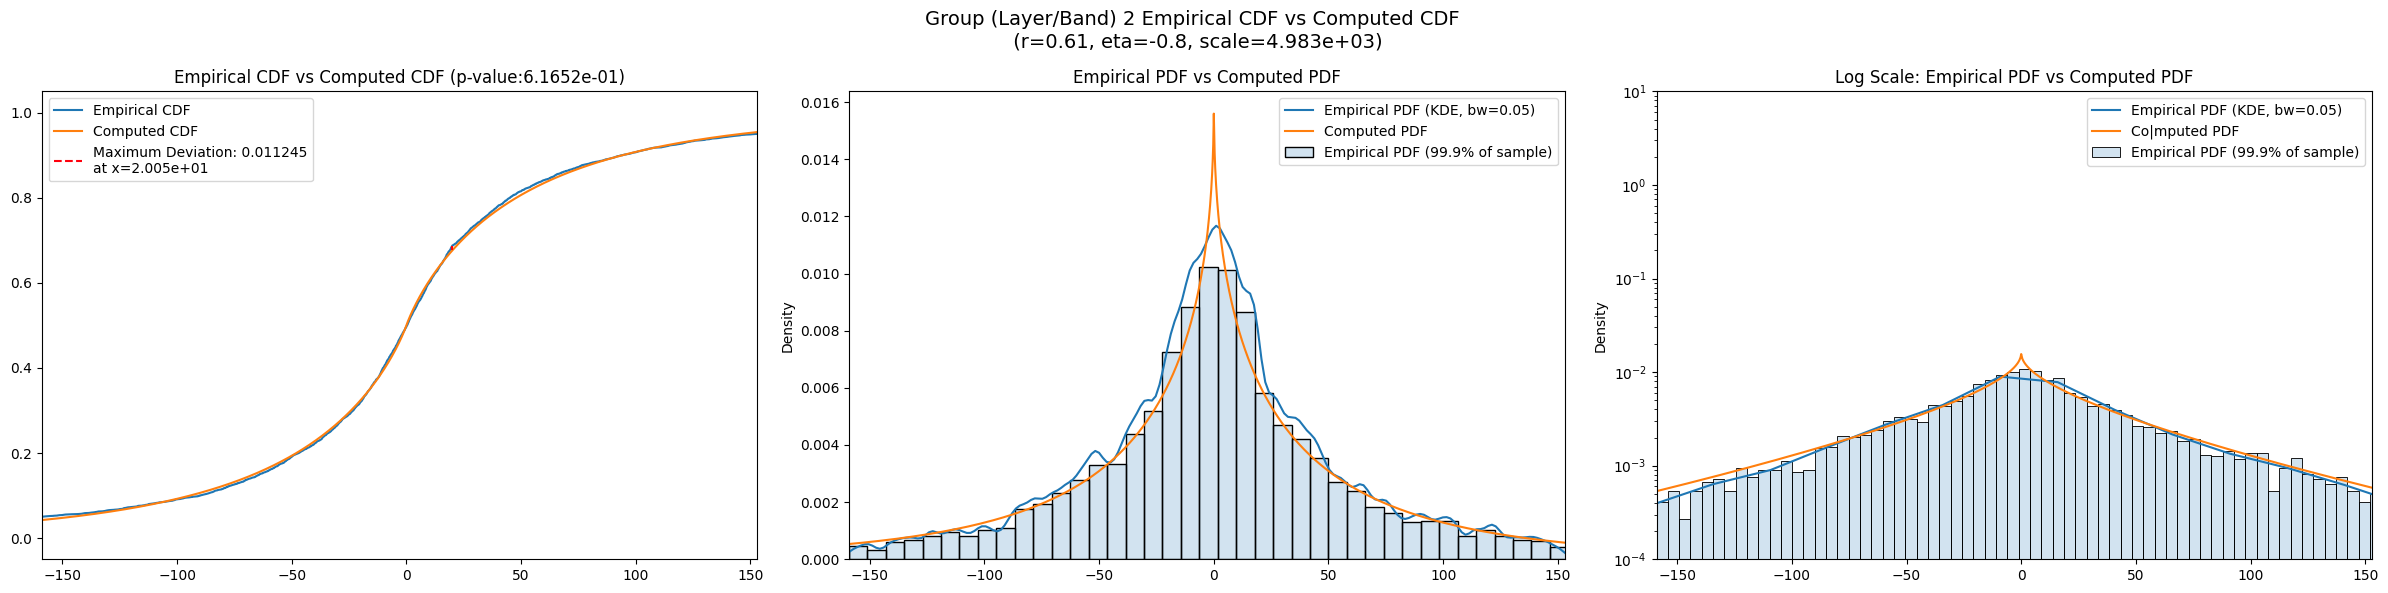

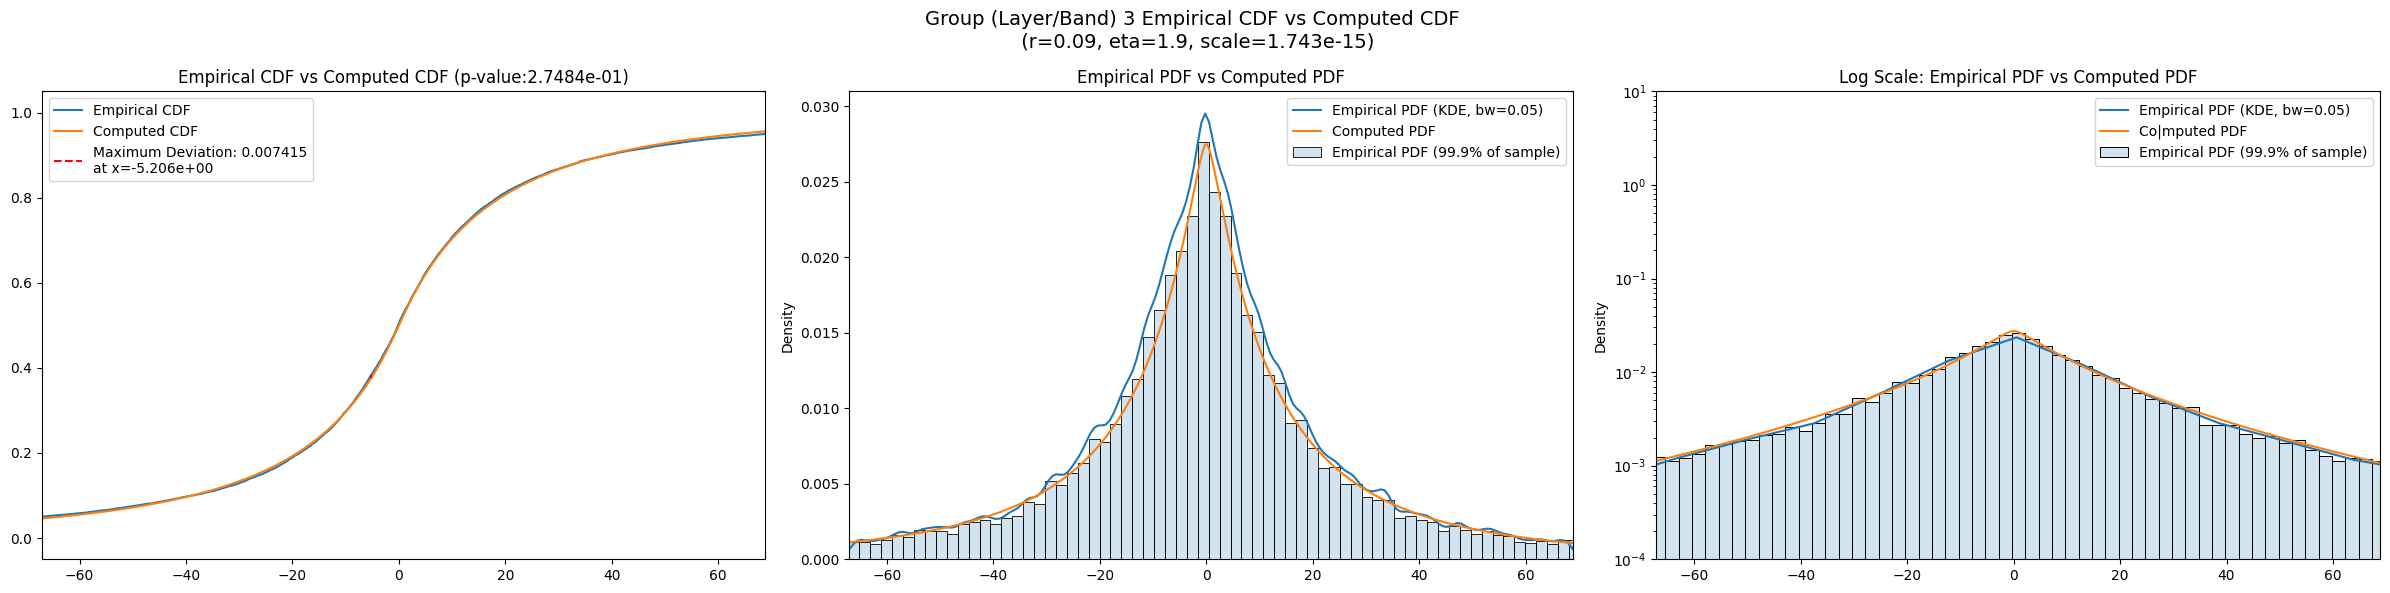

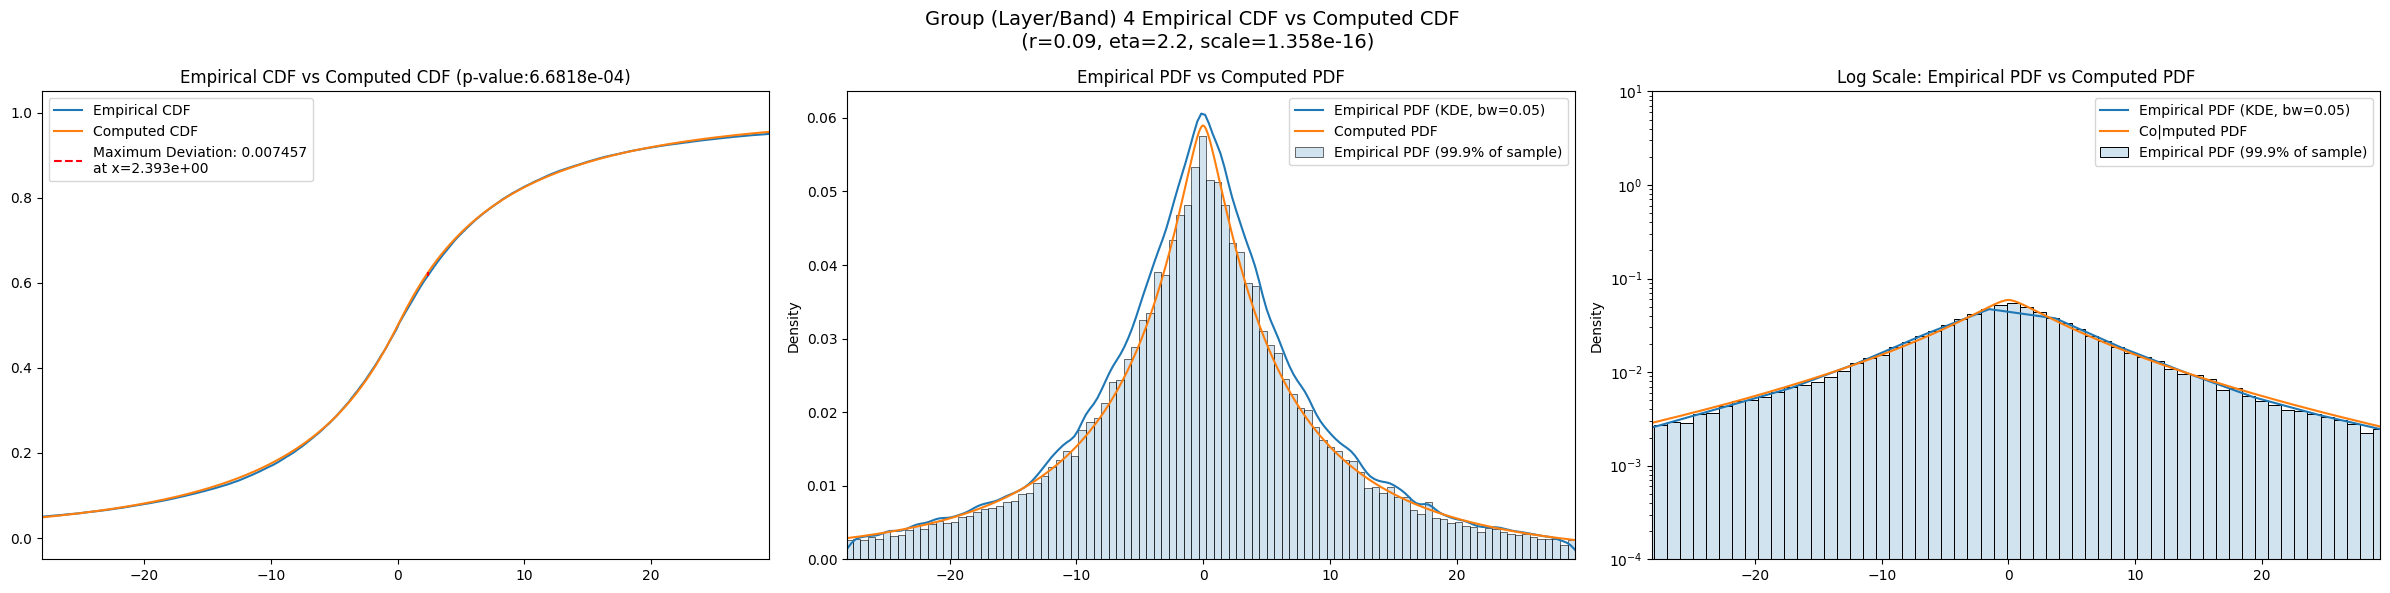

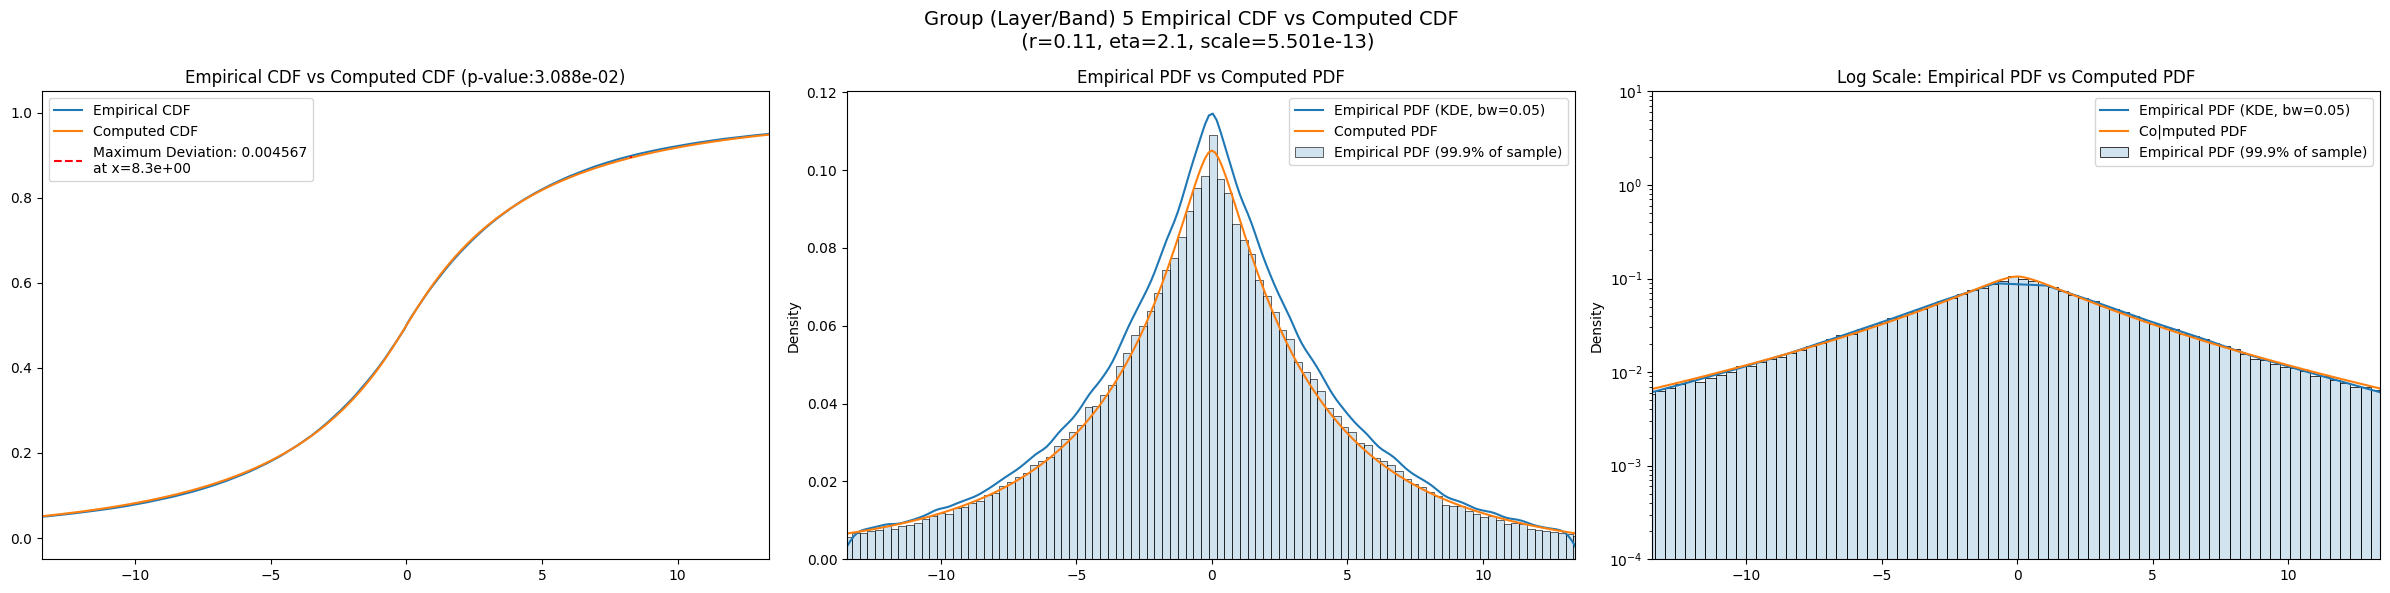

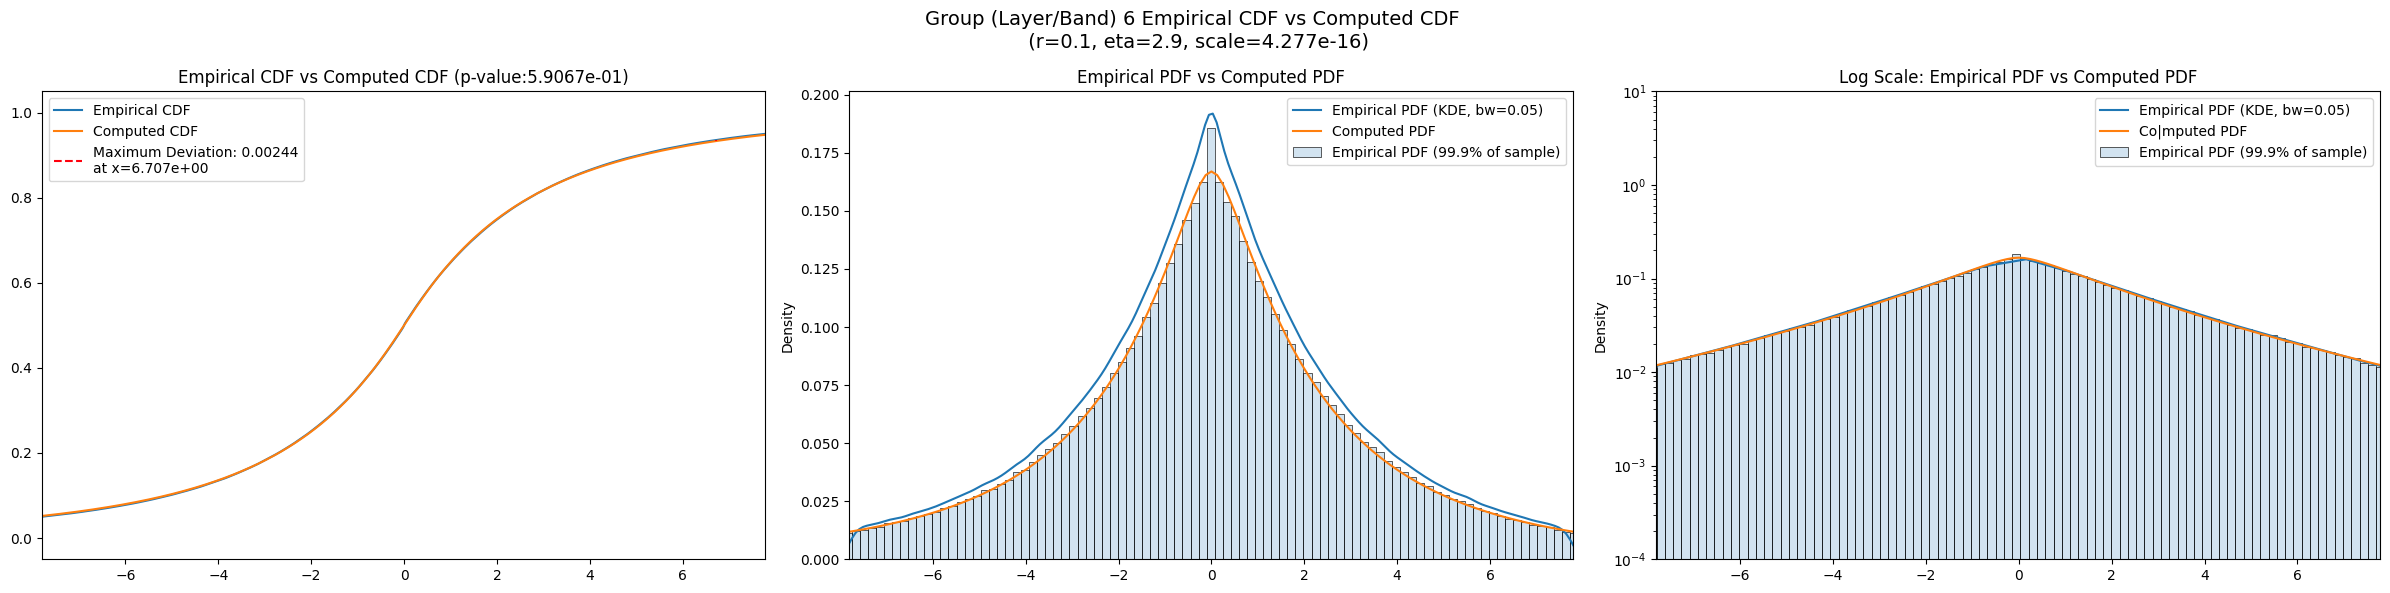

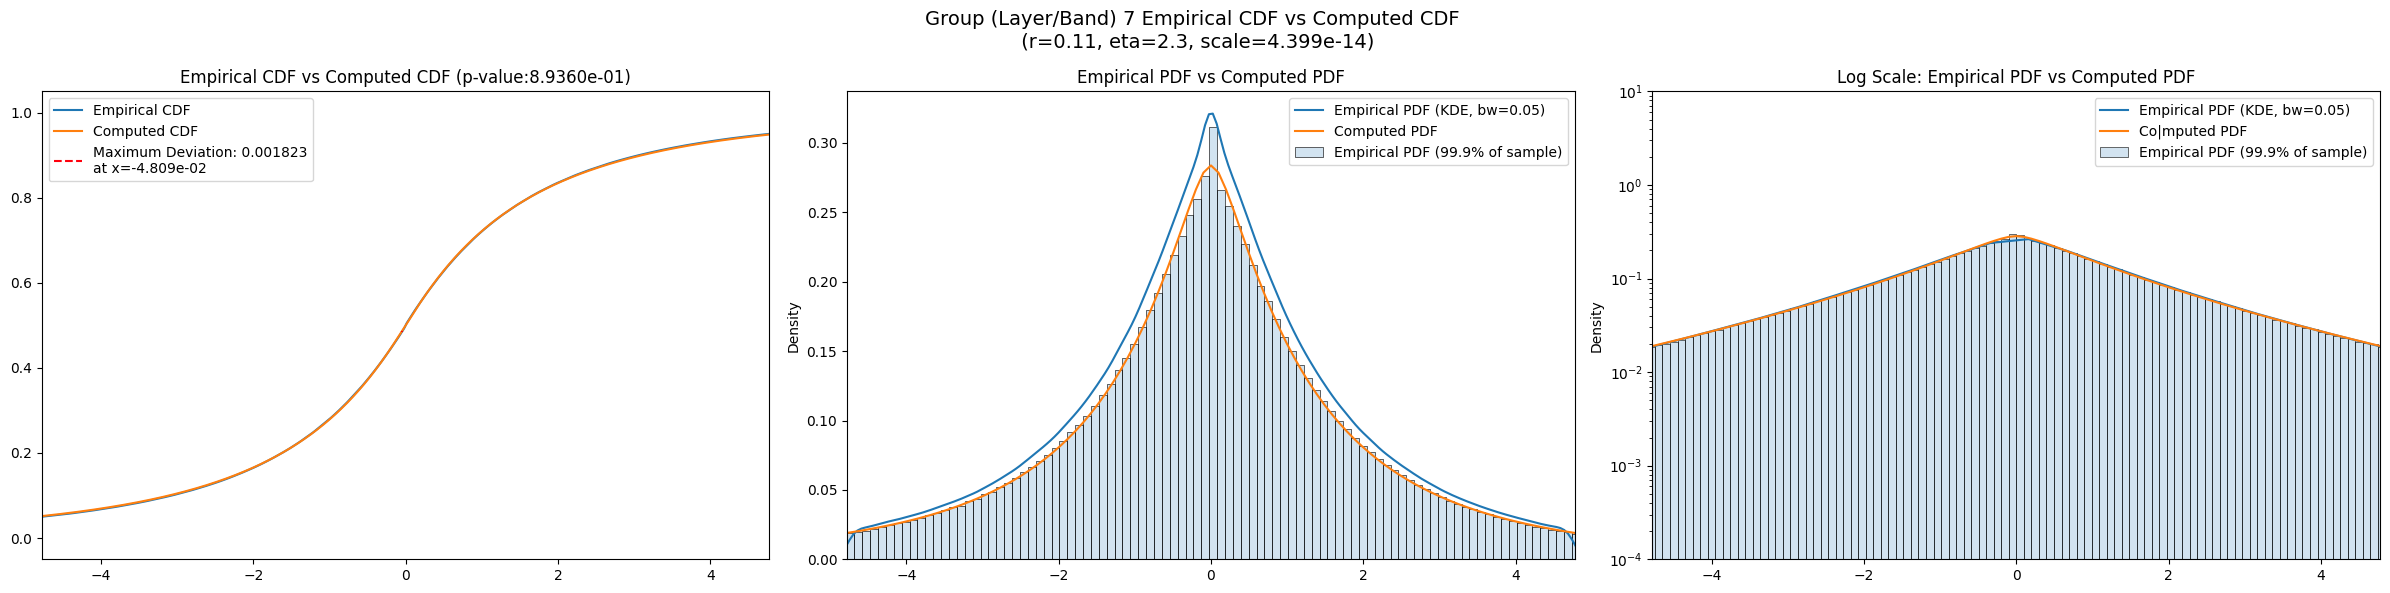

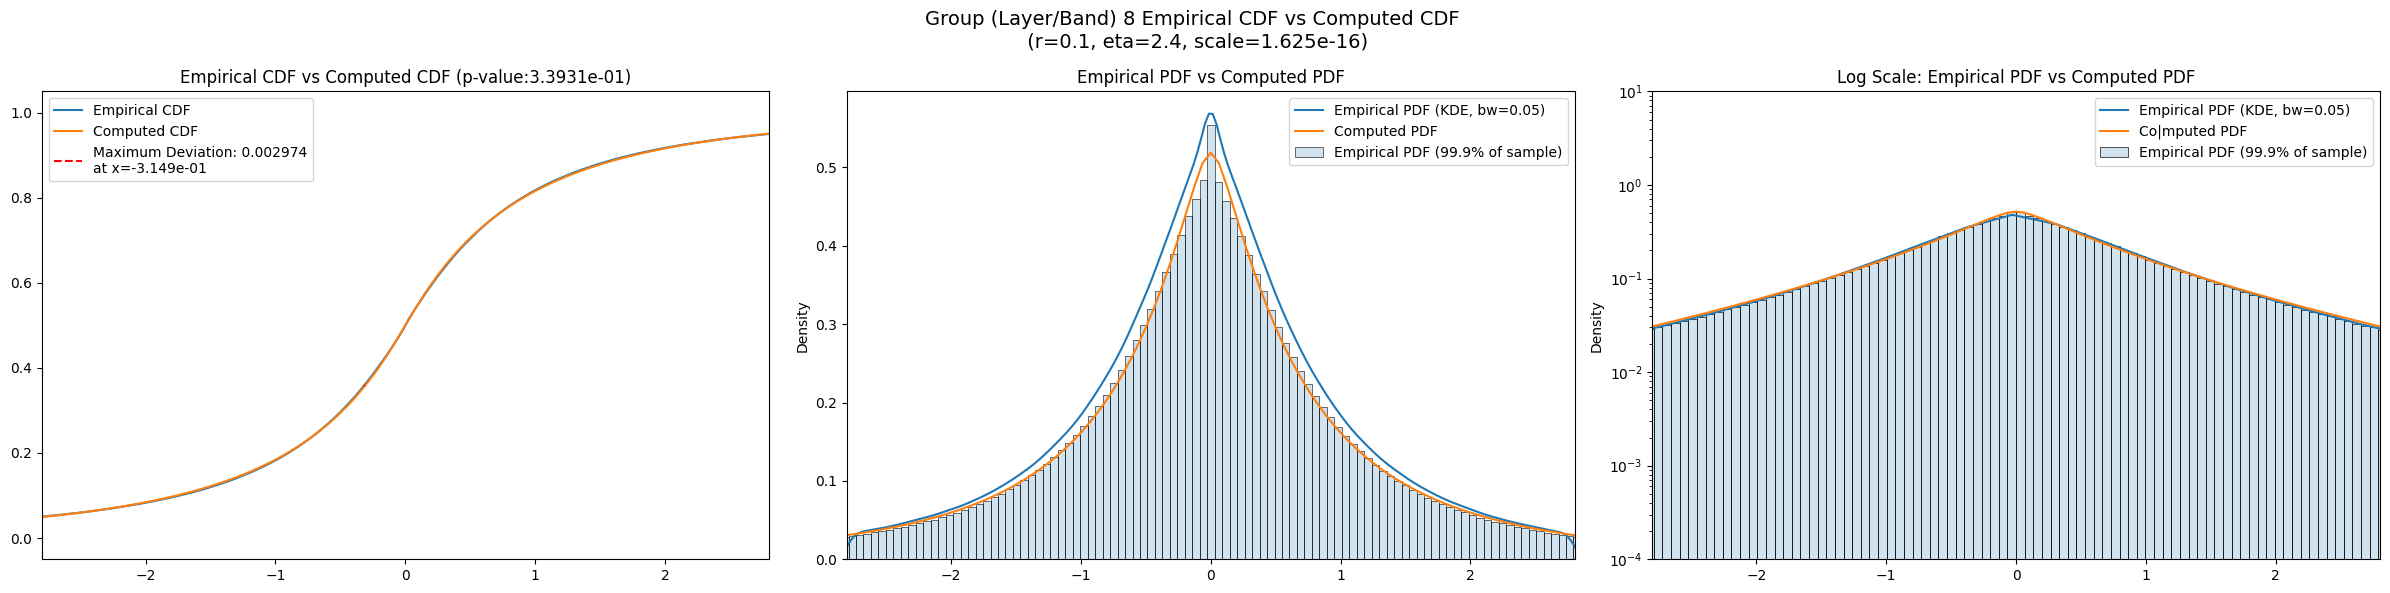

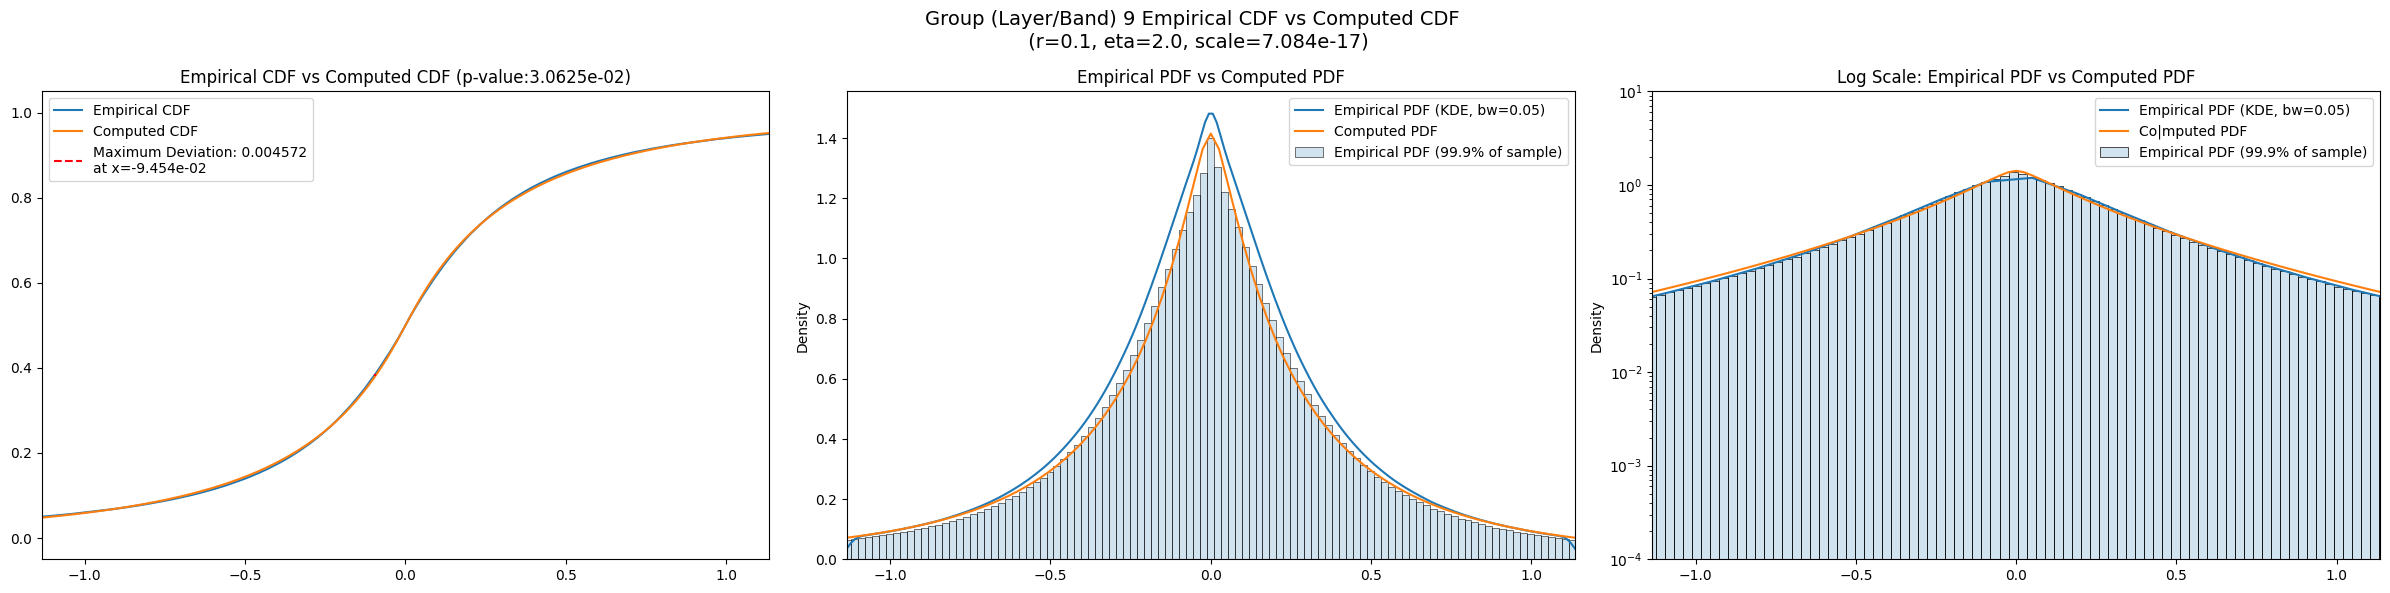

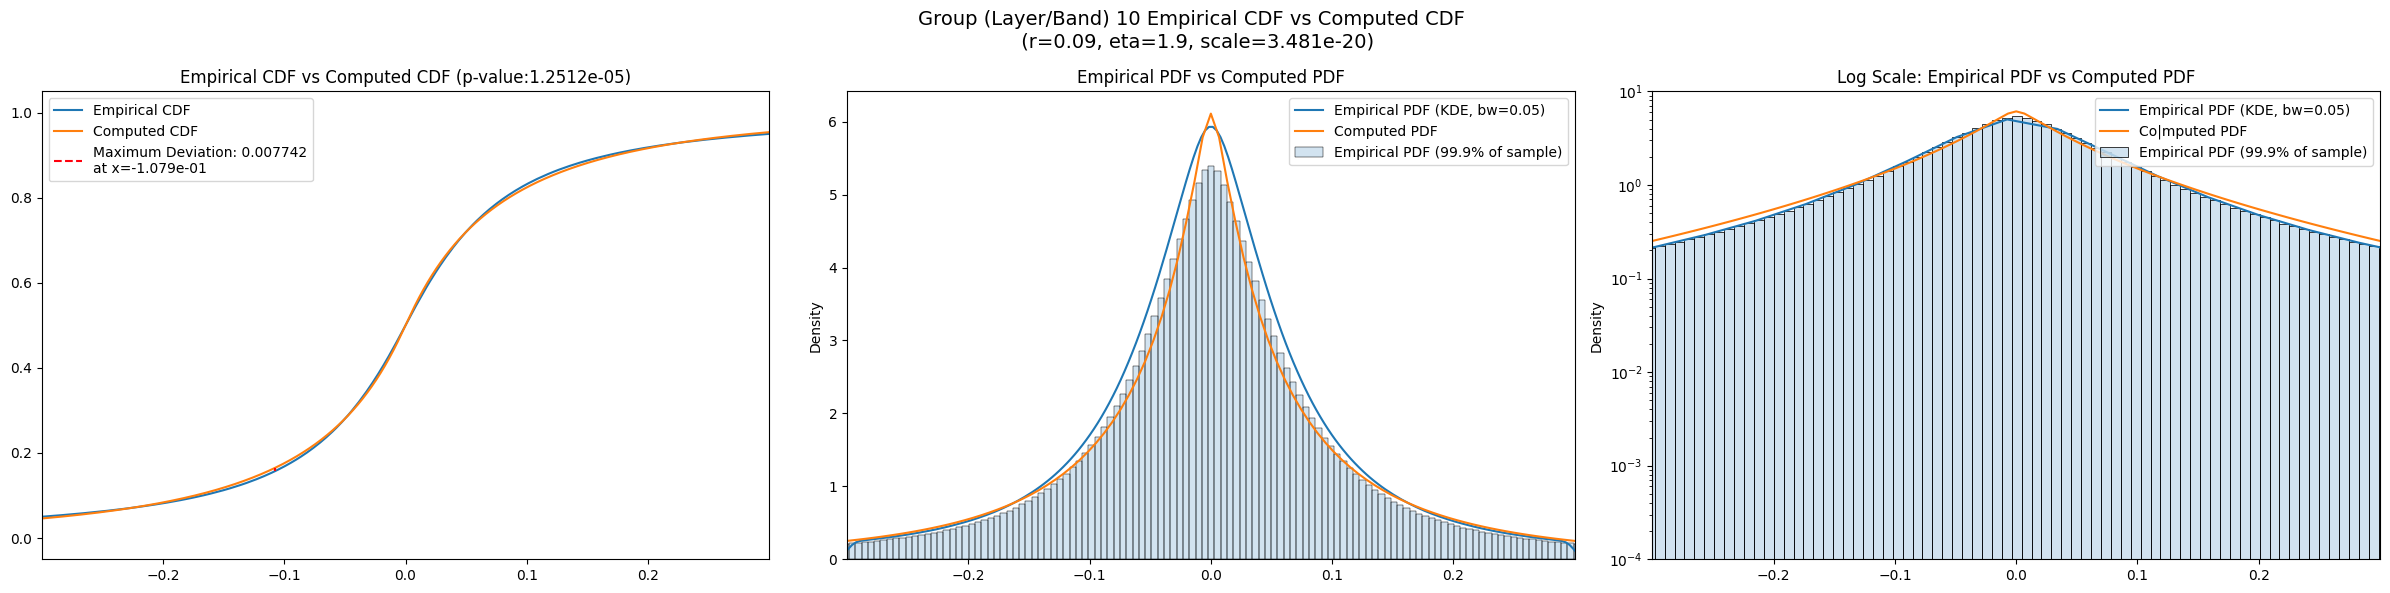

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      48477.156000  20407.244000  98426.120000   464.3678   99.549120   
3       9444.763000   5309.856400  15352.427000   431.8413  166.979080   
4       2098.490200    931.151060   4352.503000  1066.9325  136.693400   
5        347.001600    166.507490    821.238000  1301.6492   85.055270   
6         95.132810     42.791160    309.412260  3018.1877   62.344480   
7         27.165165     14.275747     79.906204  2270.9495   50.703800   
8         10.935260      5.523009     31.109842  1948.5700   69.621250   
9          1.818054      0.995189      4.794515  1645.8049   67.103200   
10         0.179641      0.079249      0.817442  5707.5054   74.193924   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        783.3673         4500.0             0.011351        0.6         -0.8   
3        690.7381        18000.0             0.007556        0.1          1.6   
4       2116.3550        72000.0             0.008041        0.1          1.8   
5       3381.1282       288000.0             0.004838        0.1          2.4   
6       5098.2686      1152000.0             0.002360        0.1          2.9   
7       4215.7363      4608000.0             0.001856        0.1          2.7   
8       4228.2856     18432000.0             0.003111        0.1          2.4   
9       3605.7570     73728000.0             0.005405        0.1          2.1   
10      6393.3745    294912000.0             0.008019        0.1          1.6   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       58.695100              0.053636          1.082640e-11   
3      ...       25.215700              0.053585          2.317860e-45   
4      ...       11.379700              0.048464         2.109750e-147   
5      ...        5.878040              0.040062          0.000000e+00   
6      ...        3.512580              0.037991          0.000000e+00   
7      ...        2.113370              0.039507          0.000000e+00   
8      ...        1.197870              0.041872          0.000000e+00   
9      ...        0.461959              0.045104          0.000000e+00   
10     ...        0.113484              0.049417          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          52.332200             0.028170         1.551580e-03  41.554200   
3          22.426500             0.027906         1.305310e-12  17.557000   
4          10.117700             0.023408         1.051410e-34   7.981460   
5           5.231900             0.015280         7.743140e-59   4.123280   
6           3.106430             0.011823        2.652470e-140   2.480920   
7           1.864840             0.012933         0.000000e+00   1.494310   
8           1.060500             0.016225         0.000000e+00   0.842271   
9           0.410614             0.020332         0.000000e+00   0.324212   
10          0.101288             0.025537         0.000000e+00   0.079845   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.025853   4.795680e-03          6.308214e-01  
3           0.025085   2.848650e-10          2.606398e-01  
4           0.018709   2.539820e-22          5.049547e-04  
5           0.011820   2.208150e-35          1.033265e-05  
6           0.011664  1.494490e-136          5.364667e-06  
7           0.012296   0.000000e+00          1.729315e-13  
8           0.012942   0.000000e+00         2.228344e-155  
9           0.015106   0.000000e+00          0.000000e+00  
10          0.018896   0.000000e+00       

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.011351                 0.020208          0.011111   
3                 0.007556                 0.010113          0.007510   
4                 0.008041                 0.005059          0.007582   
5                 0.004838                 0.002530          0.004597   
6                 0.002360                 0.001265          0.002360   
7                 0.001856                 0.000633          0.001807   
8                 0.003111                 0.000316          0.003111   
9                 0.005405                 0.000158          0.004952   
10                0.008019                 0.000079          0.007401   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.053636             0.028170       0.025853  
3                  0.053585             0.027906       0.025085  
4                  0.048464             0.023408       0.018709  
5                  0.040062             0.015280       0.011820  
6                  0.037991             0.011823       0.011664  
7                  0.039507             0.012933       0.012296  
8                  0.041872             0.016225       0.012942  
9                  0.045104             0.020332       0.015106  
10                 0.049417             0.025537       0.018896

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             8848.582031          0.011111    0.61      -0.8  4.983389e+03   
3             2284.004883          0.007510    0.09       1.9  1.742907e-15   
4              410.879028          0.007582    0.09       2.2  1.357614e-16   
5               91.731453          0.004597    0.11       2.1  5.501007e-13   
6               30.260470          0.002360    0.10       2.9  4.276594e-16   
7               11.398344          0.001807    0.11       2.3  4.398515e-14   
8                3.856113          0.003111    0.10       2.4  1.624656e-16   
9                0.637854          0.004952    0.10       2.0  7.084128e-17   
10               0.045611          0.007401    0.09       1.9  3.480539e-20   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                     50.0  
4                    250.0  
5                    275.0  
6                    150.0  
7                    100.0  
8                    150.0  
9                    225.0  
10                   300.0

In [21]:
eng.quit()